In [1]:
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
import   parameters
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import arima
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error,mean_squared_error
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

starting of paralle.py
paralle.py/parallel is printing


In [6]:
# top 3
# C+ St Plk
# C+ St NT3
# Pr Plk


# region top
# North Atlantic
# Carolinas
# Midwest East
# Midwest Central
# Texas and South Plains
# Pacific Northwest            

In [2]:
def preprocess_data(df,region,forecast):
    df=df[df['Product Segment'].isin(['Exterior','Interior'])]
    df=df[df['Region Name']!='Export/Interco']
    df=df[df['Region Name']==region]
    df=df[df['forecast_group']==forecast]
    df=df[['Order Create Date','Order Volume (STD)']] # columns you want
    df['Order Create Date']=pd.to_datetime(df['Order Create Date'])
    df=df.sort_values(by='Order Create Date')
    df=df.reset_index(drop=True)
    df['year'] = df['Order Create Date'].dt.year
    df['month'] = df['Order Create Date'].dt.month
    df = df.groupby(['year', 'month'])['Order Volume (STD)'].sum().reset_index()
    df['date']=df['year'].astype('string')+'-'+df['month'].astype('string')+'-01'
    df.set_index('date',inplace=True)
    df=df.drop(['year','month'],axis=1)
    df.index=pd.to_datetime(df.index)
    return df
# check stationary test dickey fuller test
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")


In [44]:
forecast='C+ St NT3' # Pr Plk,C+ St NT3,C+ St Plk  , Pr Plk  , North Atlantic  ,C+ St NT3  Pr Plk	 Midwest Central_C+ St NT3
region='Midwest Central' # Carolinas 	Midwest East 	Midwest Central 	Texas and South Plains ,Pacific Northwest
df=pd.read_parquet('tezcatli_orders_data.parquet')

In [45]:
df=preprocess_data(df,region,forecast)

In [19]:
adf_test(df['Order Volume (STD)'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.650541
p-value                   0.456758
# lags used               3.000000
# observations          120.000000
critical value (1%)      -3.486056
critical value (5%)      -2.885943
critical value (10%)     -2.579785
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [20]:
adf_test(df['Order Volume (STD)'].diff(1).dropna())

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.969802e+00
p-value                 2.256154e-17
# lags used             2.000000e+00
# observations          1.200000e+02
critical value (1%)    -3.486056e+00
critical value (5%)    -2.885943e+00
critical value (10%)   -2.579785e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [21]:
# data has seasonality and it is yearly seasonal

In [22]:
for date, name in sorted(us_holidays.items()):
    print(f"{date}: {name}")

2023-01-01: New Year's Day
2023-01-02: New Year's Day (Observed)
2023-01-16: Martin Luther King Jr. Day
2023-02-20: Washington's Birthday
2023-05-29: Memorial Day
2023-06-19: Juneteenth National Independence Day
2023-07-04: Independence Day
2023-09-04: Labor Day
2023-10-09: Columbus Day
2023-11-10: Veterans Day (Observed)
2023-11-11: Veterans Day
2023-11-23: Thanksgiving
2023-12-25: Christmas Day


In [35]:
import holidays
formatted_dates= []
for i in range(2013,2024):
    us_holidays = holidays.US(years=i)
    l=[]
    for date, name in sorted(us_holidays.items()):
        l.append(date)
    formatted_dates.extend([date.strftime('%Y-%m-%d') for date in l])


In [36]:
df.head(11)

,Order Volume (STD)
date,
2013-04-01,4469831.5
2013-05-01,4444568.0
2013-06-01,4224175.0
2013-07-01,5902577.0
2013-08-01,6095172.5
2013-09-01,4927286.5
2013-10-01,4194547.0
2013-11-01,3549979.0
2013-12-01,3178264.5


In [25]:
# from pandas.tseries.holiday import USFederalHolidayCalendar
# from pandas.tseries.offsets import CustomBusinessDay
# usb = CustomBusinessDay(calendar = USFederalHolidayCalendar())
# holiday=pd.date_range('7/1/2014', '7/10/2023', freq=usb)

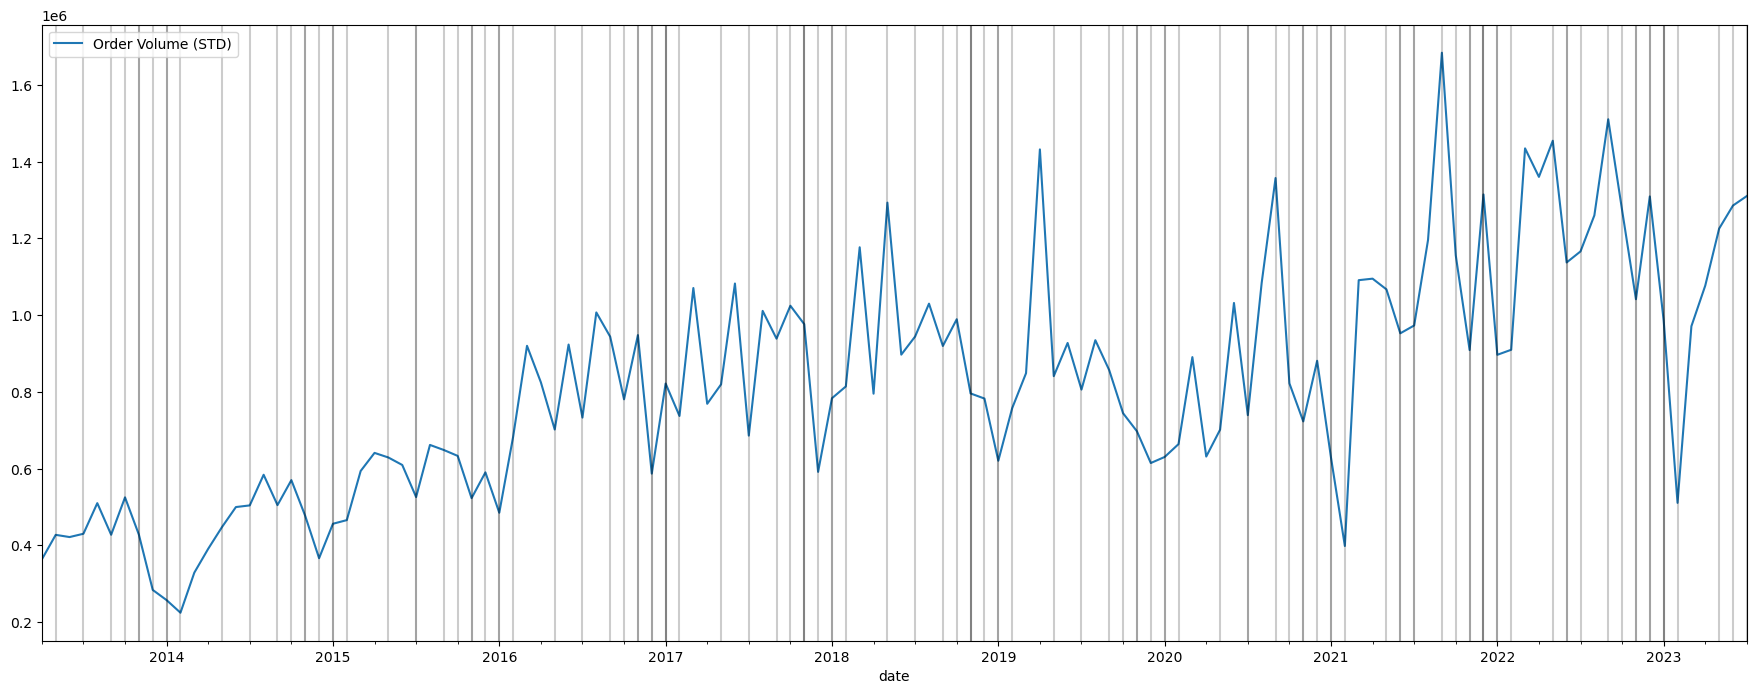

In [46]:
ax=df.plot(figsize=(22,8))
for x in formatted_dates:
    ax.axvline(x=x,color='k',alpha=0.2)

In [47]:
df['holiday']=np.where(df.index.isin(formatted_dates),1,0)

auto_arima_result                                      SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  124
Model:             SARIMAX(2, 0, 2)x(0, 0, 2, 12)   Log Likelihood               -1678.269
Date:                            Wed, 06 Sep 2023   AIC                           3372.539
Time:                                    17:58:26   BIC                           3395.101
Sample:                                04-01-2013   HQIC                          3381.704
                                     - 07-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.315e+05   1.24e+05      1.061      0.289   -1.11e+05    3.75e+05
ar.L1         -0.

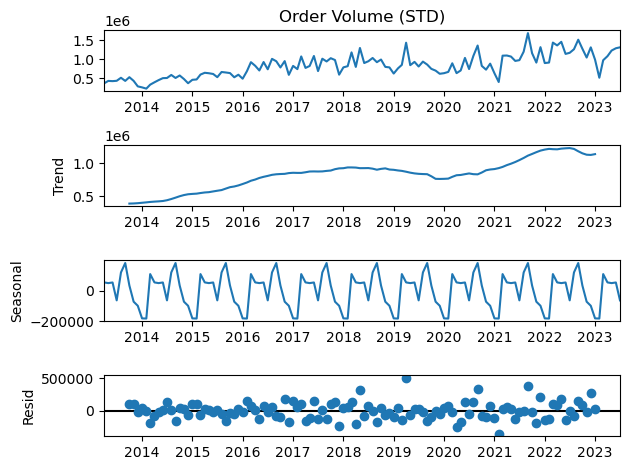

In [48]:
sd=seasonal_decompose(df['Order Volume (STD)'])
sd.plot();
auto_arima_result=auto_arima(df['Order Volume (STD)'],seasonal=True,m=12,start_p=1,d=1,max_p=8,max_d=6,max_q=8,D=4,max_P=6,max_D=4,stationary=True,exogeneous=df[['holiday']]).summary()
print('auto_arima_result',auto_arima_result)

In [49]:
def allinOne_val(df,p,d,q,seasonal_order,trend_offsetint=None):
    # df.plot()
    # sd=seasonal_decompose(df['Order Volume (STD)'])
    # sd.plot();
    # auto_arima_result=auto_arima(df['Order Volume (STD)'],seasonal=True,m=m,start_p=1,d=1,max_p=8,max_d=6,max_q=8,D=4,max_P=6,max_D=4,stationary=True).summary()
    # print('auto_arima_result',auto_arima_result)
    train=df[:'2022-06-01']
    val=df['2022-07-01':'2023-01-01']
    # test=df['2023-02-01':]
    start=len(train)
    end=len(train) + len(val)-1
    model=SARIMAX(train['Order Volume (STD)'],exog=train['holiday'],order=(p, d, q),trend_offsetint=1,seasonal_order=seasonal_order,enforce_invertibility=False)
    results=model.fit()
    predictions_val=results.predict(start,end,exog=val[['holiday']]).rename('SARIMAX  predict')
    val['Order Volume (STD)'].plot(figsize=(12,6),legend=True,title='Validation plot ')
    predictions_val.plot(legend=True)
    plt.show()
    print('mean_absolute_percentage_error of validation',mean_absolute_percentage_error(val['Order Volume (STD)'],predictions_val)*100)
    print('root_mean_square_error of validation',mean_squared_error(val['Order Volume (STD)'],predictions_val)**0.5)

In [164]:
parameters.param['Midwest Central_C+ St NT3'] # C+ St NT3	SARIMAX(2, 0, 2)x(0, 0, 2, 12)  Pacific Northwest

(2, 0, 2, (0, 0, 2, 12))

/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45591D+01    |proj g|=  1.84729D+00

At iterate    5    f=  1.43567D+01    |proj g|=  3.08305D-02

At iterate   10    f=  1.43564D+01    |proj g|=  3.61805D-03

At iterate   15    f=  1.43544D+01    |proj g|=  5.53102D-02

At iterate   20    f=  1.43507D+01    |proj g|=  6.55116D-03

At iterate   25    f=  1.43491D+01    |proj g|=  1.07110D-02

At iterate   30    f=  1.43404D+01    |proj g|=  5.40684D-02

At iterate   35    f=  1.43369D+01    |proj g|=  4.13433D-03

At iterate   40    f=  1.43368D+01    |proj g|=  3.03974D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

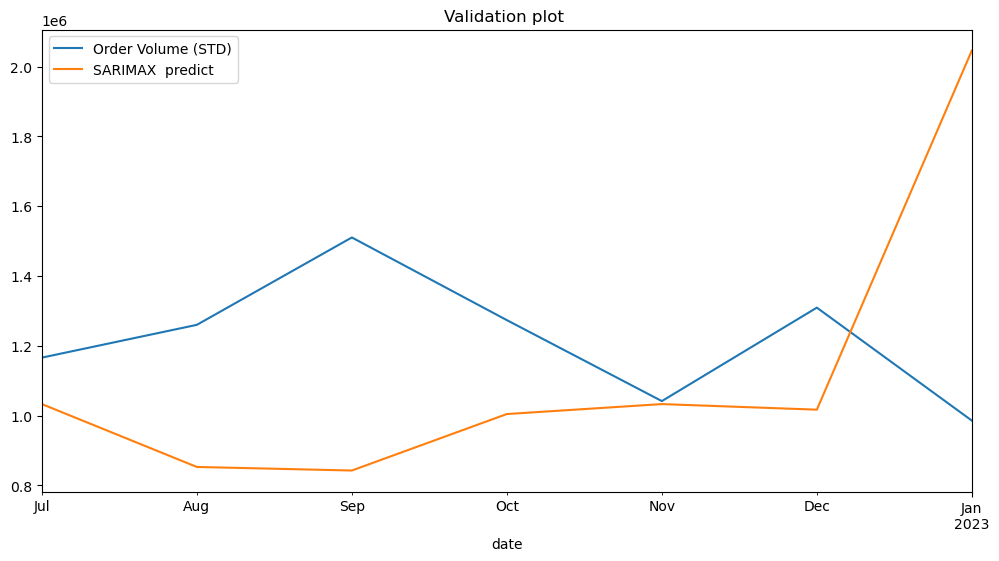

mean_absolute_percentage_error of validation 34.26033582405966
root_mean_square_error of validation 522576.7040324173


In [50]:
p,d,q,seasonal_order= parameters.param['Midwest Central_C+ St NT3'] # CHANGE POINT   SARIMAX(3, 0, 0)x(1, 0, 0, 12) 
allinOne_val(df,p,d,q,seasonal_order=seasonal_order) 

In [42]:
def allinOne(df,p,d,q,seasonal_order,trend_offsetint=None):
    # df.plot()
    # sd=seasonal_decompose(df['Order Volume (STD)'])
    # sd.plot();
    # auto_arima_result=auto_arima(df['Order Volume (STD)'],seasonal=True,m=m,start_p=1,d=1,max_p=8,max_d=6,max_q=8,D=4,max_P=6,max_D=4,stationary=True).summary()
    # print('auto_arima_result',auto_arima_result)
    train=df[:'2023-01-01']
    # val=df['2022-07-01':'2023-01-01']
    test=df['2023-02-01':]
    start=len(train)
    end=len(train) + len(test)-1
    model=SARIMAX(train['Order Volume (STD)'],order=(p, d, q),trend_offsetint=1,seasonal_order=seasonal_order,exog=train['holiday'])
    results=model.fit()
    predictions_val=results.predict(start,end,exog=test[['holiday']]).rename('SARIMAX  predict')
    test['Order Volume (STD)'].plot(figsize=(12,6),legend=True,title='Actual vs Predicted plot ')
    predictions_val.plot(legend=True)
    plt.show()
    print('mean_absolute_percentage_error of validation',mean_absolute_percentage_error(test['Order Volume (STD)'],predictions_val)*100)
    print('root_mean_square_error of validation',mean_squared_error(test['Order Volume (STD)'],predictions_val)**0.5)

/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61463D+01    |proj g|=  6.10515D-01

At iterate    5    f=  1.59378D+01    |proj g|=  3.28008D-02

At iterate   10    f=  1.59341D+01    |proj g|=  2.60133D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   3.988D-06   1.593D+01
  F =   15.934092048451030     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


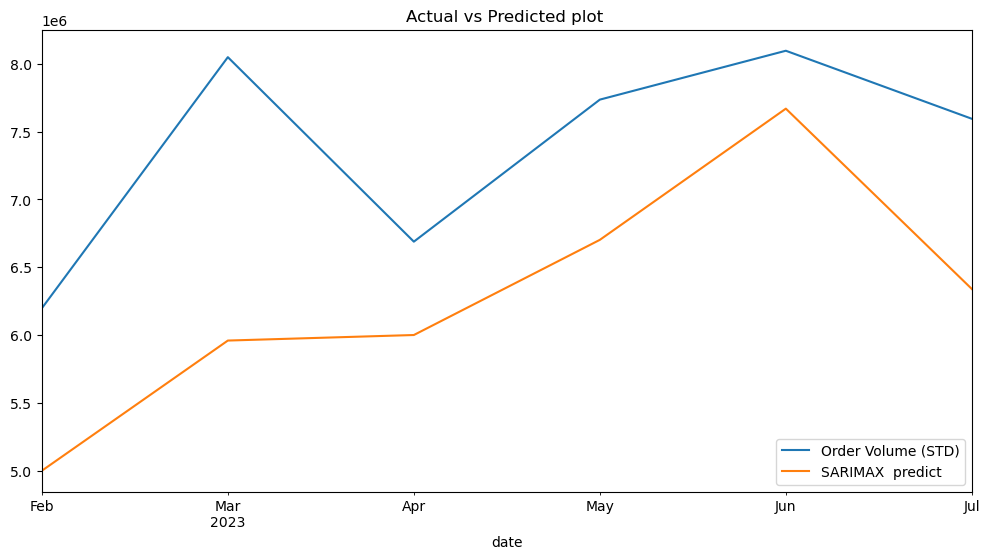

mean_absolute_percentage_error of validation 15.125637206477673
root_mean_square_error of validation 1231765.9563874472


In [43]:
allinOne(df,p,d,q,seasonal_order=seasonal_order)

In [13]:
# # test=df['2022-11-01':]
# start=len(train_1)
# end=len(train_1) + 10
# model=SARIMAX(train_1['Order Volume (STD)'],order=(1, 2, 10),seasonal_order=(4,5,3,12))
# results=model.fit()
# predictions=results.predict(start,end).rename('SARIMAX  predict')

In [14]:
# train=df[:'2022-10-01']
# # val=df[:'2022-10-01']
# test=df['2022-11-01':]
# start=len(train)
# end=len(train) + len(test)-1
# model=SARIMAX(train['Order Volume (STD)'],order=(5, 4, 1),seasonal_order=(1,0,0,12))
# model.initialize_approximate_diffuse()
# results=model.fit()
# predictions=results.predict(start,end).rename('SARIMAX  predict')
# test['Order Volume (STD)'].plot(figsize=(12,6),legend=True)
# predictions.plot(legend=True)
# plt.ylabel('Order Volume (STD)')
# plt.title('Comaparison Actual vs Predited')
# plt.show()
# print('mean_absolute_percentage_error_val',mean_absolute_percentage_error(test['Order Volume (STD)'],predictions)*100)

### Final 

In [49]:
# model2=SARIMAX(train['Order Volume (STD)'],order=(10, 1, 10))
# results2=model2.fit()
# predictions2=results2.predict(start,end).rename('SARIMAX  predict')
# test['Order Volume (STD)'].plot(figsize=(12,6),legend=True,label='Order Volume (STD) Actual')
# predictions2.plot(legend=True)
# # plt.xticks('')
# plt.ylabel('Order Volume (STD)')
# plt.title('Comaparison Actual vs Predited')
# print('mean_absolute_error',mean_absolute_error(test['Order Volume (STD)'],predictions2))
# print("MAPE",mean_absolute_percentage_error(test['Order Volume (STD)'],predictions2))

In [ ]:
# import pandas as pd
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_absolute_error
# import matplotlib.pyplot as plt

# # Load your time series data into a pandas DataFrame
# # Replace this with your actual data loading code
# data = pd.read_csv('your_time_series_data.csv')

# # Choose the split points
# train_end = int(len(data) * 0.7)  # 70% for training
# val_end = int(len(data) * 0.85)   # 15% for validation, remaining for test

# # Split the data
# train = data[:train_end]
# validation = data[train_end:val_end]
# test = data[val_end:]

# # Fit the model on the training data
# model = SARIMAX(train['Order Volume (STD)'], order=(10, 1, 10))
# results = model.fit()

# # Make predictions on the validation set
# predictions_val = results.predict(start=len(train), end=len(train) + len(validation) - 1)

# # Calculate mean absolute error on the validation set
# mae_val = mean_absolute_error(validation['Order Volume (STD)'], predictions_val)
# print('Validation MAE:', mae_val)

# # Make predictions on the test set
# predictions_test = results.predict(start=len(train) + len(validation), end=len(data) - 1)

# # Calculate mean absolute error on the test set
# mae_test = mean_absolute_error(test['Order Volume (STD)'], predictions_test)
# print('Test MAE:', mae_test)

# # Plot the actual data, validation predictions, and test predictions
# plt.figure(figsize=(12, 6))
# data['Order Volume (STD)'].plot(label='Actual')
# predictions_val.plot(label='Validation Predictions')
# predictions_test.plot(label='Test Predictions')
# plt.legend()
# plt.title('SARIMA Model: Actual vs. Predicted')
# plt.xlabel('Time')
# plt.ylabel('Order Volume (STD)')
# plt.show()
